# Contents
- [Introduction of Dataset](#Introduction-of-Dataset)
    - [Summary](#Summary)
    - [Brief descriptions](#Brief-descriptions)
    - [Data format](#Data-format)
- [Introduction of Methods](#Introduction-of-Methods)
- [Metric](#Metric)
- [Implementation](#Implementation)
    - [Import modules](#Import-modules)
    - [Function definition](#Function-definition)
        - [Load data](#Load-data)
        - [Convert raw data to dense matrix](#Convert-raw-data-to-dense-matrix)
        - [Similarity Matrix](#Similarity-Matrix)
        - [RMSE](#RMSE)
    - [Main](#Main)
        - [Load train data set and test data set](#Load-train-data-set-and-test-data-set)
        - [Singular value decomposition](#Singular-value-decomposition)
        - [Compress matrix](#Compress-matrix)
        - [Calculate similarity matrix](#Calculate-similarity-matrix)
        - [Compress matrix](#Compress-matrix)
        - [Predict](#Predict)
            - [According to user similarity](#According-to-user-similarity)
            - [According to item similarity](#According-to-item-similarity)
        - [Estimate results](#Estimate-results)
        - [Show results as images](#Show-results-as-images)

# Introduction of Dataset

[MovieLens](https://grouplens.org/datasets/movielens/) is the oldest recommendation system. Founded by the GroupLens project team of the School of Computer Science and Engineering, Minnesota University, USA, it is a non-commercial, research-oriented experimental site. Movie Lens mainly uses a combination of Collaborative Filtering and Association Rules to recommend movies of interest to users.

## Summary

[MovieLens 100K Dataset](http://files.grouplens.org/datasets/movielens/ml-100k.zip) consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies. 
- Simple demographic info for the users (age, gender, occupation, zip)

## Brief descriptions

- ml-data.tar.gz   -- Compressed tar file.
        To rebuild the u data files do this:
            gunzip ml-data.tar.gz
            tar xvf ml-data.tar
            mku.sh
                
- u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
        - Each user has rated at least 20 movies.  
        - Users and items are numbered consecutively from 1.  
        - The data is randomly ordered. 
        - This is a tab separated list of 
            user id | item id | rating | timestamp. 
        - The time stamps are unix seconds since 1/1/1970 UTC   

- u.info     -- The number of users, items, and ratings in the u data set.

- u.item     -- Information about the items (movies); 
        This is a tab separated list of
            movie id | movie title | release date | video release date |
            IMDb URL | unknown | Action | Adventure | Animation |
            Children's | Comedy | Crime | Documentary | Drama | Fantasy |
            Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
            Thriller | War | Western |
        The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once. The movie ids are the ones used in the u.data data set.

- u.genre    -- A list of the genres.

- u.user     -- Demographic information about the users; 
        This is a tab separated list of
            user id | age | gender | occupation | zip code
        The user ids are the ones used in the u.data data set.
              
- u.occupation -- A list of the occupations.

- u\*.base & u\*.test  -- data sets
    - The data sets u1.base and u1.test through u5.base and u5.test are 80%/20% splits of the u data into training and test data.
    - The data sets ua.base, ua.test, ub.base, and ub.test split the u data into a training set and a test set with exactly 10 ratings per user in the test set.
    - Each of u1, ..., u5 have disjoint test sets; this if for 5 fold cross validation (where you repeat your experiment with each training and test set and average the results).
    - The sets ua.test and ub.test are disjoint.
    - These data sets can be generated from u.data by mku.sh.

- allbut.pl  -- The script that generates training and test sets where all but n of a users ratings are in the training data.

- mku.sh     -- A shell script to generate all the u data sets from u.data.

## Data format

The format of `u1.base` is as follows.

| user id | movied id | rating | timestamp |
| ------- | --- | ------ | ---------- |
| 1	| 1	| 5	| 874965758 |
| 1	| 2	| 3	| 876893171 |
| 1	| 3	| 4	| 878542960 |
| 1	| 4	| 3	| 876893119 |
| 1	| 5	| 3	| 889751712 |
| $\cdots$ | $\cdots$ | $\cdots$ | $\cdots$ |
| 2 |  1  |	4 |	888550871 |
| 2 |  10 |	2 |	888551853 |
| 2 |  14 |	4 |	888551853 |
| 2 |  25 |	4 |	888551648 |
| 2 | 100 |	5 |	888552084 |
| $\cdots$ | $\cdots$ | $\cdots$ | $\cdots$ |

# Introduction of Methods

The data is loaded as two matrixes $M_{train}, M_{test}$.
$$
M = \left[ \begin{matrix}
    r_{11} & \cdots & r_{1N_{item}} \\
   \cdots & \cdots & \cdots \\
    r_{N_{user}1} & \cdots & r_{N_{user}N_{item}} \\
\end{matrix} \right]
$$

Take Predictions according to **user similarity** as an example.

1. Decompose $M_{train}$ using SVD;
    $$ M_{train} = U \Sigma V^T $$
    
2. Compress matrix;
    $$ M'_{train} = M_{train} V' $$
    
    where
    $$ V' = \left[ \begin{matrix} v_1 & v_2 & \cdots & v_k \end{matrix} \right] $$
    
3. Calculate similarity matrix;
    $$ s_{ij} = \frac{{M'_i}^T M'_j}{||M'_i|| || M'_j||} $$
    
    where $M'_i$ is the $i$th row of matrix $M'$
    
4. Calculate predicted rating according to similarity.

    For example, in order to predict the $r$th user's rating to the $c$th item, choose $n$ users who are with the highest similarity. Then average the ratings of these users and take the average value as the predicted rating.
    

# Metric

RMSE is used to estimate predicted results
$$ L = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y - \hat{y})^2} $$

# Implementation

## Import modules

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

## Function definition

### Load data

In [2]:
def load(path):
    """
    Params:
        path: {str}
    Returns:
        user_id: {ndarray(n)}
        item_id: {ndarray(n)}
        rating:  {ndarray(n)}
    """
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    
    df = pd.read_csv(path, sep='\t', names=header)
    n_users = max(df.user_id)
    n_items = max(df.item_id)
    
    print("Number of users = %d, Number of movies = %d" % (n_users, n_items))
    user_id = df.loc[:, 'user_id'].values
    item_id = df.loc[:, 'item_id'].values
    rating  = df.loc[:, 'rating' ].values

    return user_id, item_id, rating

### Convert raw data to dense matrix

In [3]:
def get_matrix(raw_data, shape, return_sparse=False):
    """
    Params:
        raw_data: {tuple(3)} user_id, item_id, rating
        shape:    {tuple(2)} rows, cols
        return_sparse: {bool} 
    Returns:
        m: {ndarray, sparse matrix}
    Notes:
        convert raw data to matrix(n_users, n_items)
    """
    user_id, item_id, rating = raw_data
    m = sp.coo_matrix((rating, (user_id-1, item_id-1)), shape)
    if not return_sparse:
        m = m.toarray()
    return m

### Similarity Matrix

In [4]:
def get_cosine_similarity_matrix(x):
    """
    Params:
        x: {ndarray(n_users, n_features)}
    Returns:
        cosine: {float}
    """
    x_normd = x / np.linalg.norm(x, axis=1).reshape(-1, 1)
    cosine = x_normd.dot(x_normd.T)
    return cosine

### RMSE

In [5]:
def rmse(gt, pred):
    """
    Params:
        gt: {ndarray(n_users, n_items)}
        pred: {ndarray(n_users, n_items)}
    Returns:
        score: {float}
    Notes:
        \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y - \hat{y})^2}
    """
    mask = gt != 0
    err = gt[mask] - pred[mask]
    score = np.sqrt(np.mean(err**2))
    return score

## Main

### Load train data set and test data set

In [6]:
N_USERS, N_ITEMS = 943, 1682
shape = (N_USERS, N_ITEMS)
    
train_raw = load('../origin/ml-100k/u1.base')
train_matrix = get_matrix(train_raw, shape)
test_raw  = load('../origin/ml-100k/u1.test')
test_matrix  = get_matrix(test_raw,  shape)

Number of users = 943, Number of movies = 1682
Number of users = 462, Number of movies = 1591


### Singular value decomposition

In [7]:
u, s, vh = np.linalg.svd(train_matrix)

### Compress matrix

In [8]:
rows, cols = 80, 80
train_compressed_col = train_matrix.dot(vh[: cols].T)
train_compressed_row = u.T[: cols].dot(train_matrix)

### Calculate similarity matrix

In [9]:
similarity_user = get_cosine_similarity_matrix(train_compressed_col)
similarity_item = get_cosine_similarity_matrix(train_compressed_row.T)

c:\apps\anaconda3\envs\pr\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


### Predict

#### According to user similarity

In [10]:
n_keep = 50
pred_according_to_user = np.zeros_like(test_matrix) # to preserve the predicted results
to_pred = np.array(np.where(test_matrix != 0))      # the indexes to be predicted, shape(2, n)

for i in range(to_pred.shape[1]):

    r, c = to_pred[:, i]                            # `r` is the index of user, `c` is the the index of item

    id = np.argsort(similarity_user[r])[::-1]       # sort users according to similarity in descending order
    id = id[1: n_keep + 1]                          # top `n_keep` users
    rates = train_matrix[id, c]                     # get the ratings of chosen users
    rates = rates[rates!=0]                         # filter non-zero data

    rate = np.mean(rates) if rates.shape[0] != 0 else 0
    pred_according_to_user[r, c] = rate

#### According to item similarity

In [11]:
n_keep = 100
pred_according_to_item = np.zeros_like(test_matrix) # to preserve the predicted results
to_pred = np.array(np.where(test_matrix != 0))      # the indexes to be predicted, shape(2, n)

for i in range(to_pred.shape[1]):

    r, c = to_pred[:, i]                            # `r` is the index of user, `c` is the the index of item

    id = np.argsort(similarity_item[c])[::-1]       # sort items according to similarity in descending order
    id = id[1: n_keep + 1]                          # top `n_keep` items
    rates = train_matrix[r, id]                     # get the ratings of chosen items
    rates = rates[rates!=0]                         # filter non-zero data

    rate = np.mean(rates) if rates.shape[0] != 0 else 0
    pred_according_to_item[r, c] = rate

### Estimate results

In [12]:
rmse(test_matrix, pred_according_to_user)

1.3037254312162512

In [13]:
rmse(test_matrix, pred_according_to_item)

1.1549458861782227

### Show results as images

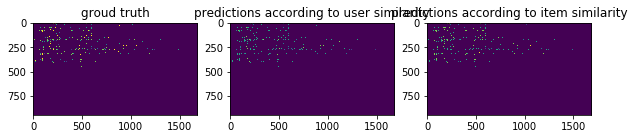

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 20))
plt.subplot(131)
plt.title('groud truth')
plt.imshow(test_matrix) 
plt.subplot(132)
plt.title('predictions according to user similarity')
plt.imshow(pred_according_to_user) 
plt.subplot(133)
plt.title('predictions according to item similarity')
plt.imshow(pred_according_to_item) 
plt.show()